**Displaying data and baseline models using pysaliency library**

In [1]:
#pysaliency is a library to extract fixations data from a set of mat files
#And compute saliency metrics for models

!git clone https://github.com/matthias-k/pysaliency.git 
!pip install ./pysaliency

import pysaliency
import sys
sys.modules[__name__] = pysaliency

Cloning into 'pysaliency'...
remote: Enumerating objects: 149, done.
remote: Counting objects: 100% (149/149), done.
remote: Compressing objects: 100% (110/110), done.
remote: Total 1804 (delta 99), reused 80 (delta 39), pack-reused 1655
Receiving objects: 100% (1804/1804), 139.34 MiB | 28.54 MiB/s, done.
Resolving deltas: 100% (1247/1247), done.
Processing ./pysaliency
     |████████████████████████████████| 174kB 5.2MB/s 
  Created wheel for pysaliency: filename=pysaliency-0.2.20-cp36-cp36m-linux_x86_64.whl size=335774 sha256=aaef2c180ce50a5d4e86d97f8d122a22ec9c8b4866878e613e41efc9e9ef904b
  Stored in directory: /tmp/pip-ephem-wheel-cache-d_0hiulb/wheels/41/88/d3/f9b878cf41eb198d3cdd33d2408b743c55342b053fb1f0a4a1
Successfully built pysaliency


**MIT1003 dataset for validating and testing the network**

*   List item
*   List item



In [2]:
                                                                                               
#MIT1003 dataset for fine tuning the readout network

import zipfile
from .datasets import FileStimuli, Stimuli, FixationTrains, Fixations, read_hdf5
import os 
import glob
import numpy as np
from natsort import natsorted
import shutil

def create_stimuli(stimuli_location, filenames, location=None, attributes=None):
    """
    Create a Stimuli class of stimuli.
    Parameters
    ----------
    @type  stimuli_location: string
    @param stimuli_location: the base path where the stimuli are located.
                             If `location` is provided, this directory will
                             be copied to `location` (see below).
    @type  filenames: list of strings
    @param filenames: lists the filenames of the stimuli to include in the dataset.
                      Filenames have to be relative to `stimuli_location`.
    @type  location: string or `None`
    @param location: If provided, the function will copy the filenames to
                     `location` and return a `FileStimuli`-object for the
                     copied files. Otherwise a `Stimuli`-object is returned.
    @returns: `Stimuli` or `FileStimuli` object depending on `location`.
    """
    if location is not None:
        shutil.copytree(stimuli_location,
                        location)
        filenames = [os.path.join(location, f) for f in filenames]

        return FileStimuli(filenames, attributes=attributes)

    else:
        filenames = [os.path.join(stimuli_location, f) for f in filenames]
        return create_memory_stimuli(filenames, attributes=attributes)

!wget http://people.csail.mit.edu/tjudd/WherePeopleLook/ALLSTIMULI.zip 
!wget http://people.csail.mit.edu/tjudd/WherePeopleLook/ALLFIXATIONMAPS.zip 

!mkdir "/content/mit"
!mkdir "/content/mit/saliencymap/"


def filter_files(filenames, ignores):
    """
    Filter a list of files, excluding all filenames which contain
    an element of `ignores` as part of their path
    """
    parts = map(full_split, filenames)
    inds = [i for i, ps in enumerate(parts)
            if not any([ignore in ps for ignore in ignores])]
    return [filenames[i] for i in inds]

def full_split(filename):
    """ split filename into all parts """
    path, basename = os.path.split(filename)
    components = [path, basename]
    while components[0] and components[0] != '/':
        first_part = components.pop(0)
        path, basename = os.path.split(first_part)
        components = [path, basename] + components

    if components[0] == '':
        components = components[1:]

    return components   

def which(program):
    """
    Check whether a program is present on the system.
    from https://stackoverflow.com/a/377028
    """
    def is_exe(fpath):
        return os.path.isfile(fpath) and os.access(fpath, os.X_OK)

    fpath, fname = os.path.split(program)
    if fpath:
        if is_exe(program):
            return program
    else:
        for path in os.environ["PATH"].split(os.pathsep):
            path = path.strip('"')
            exe_file = os.path.join(path, program)
            if is_exe(exe_file):
                return exe_file

    return None

# Stimuli
temp_dir = './'
print('Creating stimuli')
f = zipfile.ZipFile(os.path.join(temp_dir, 'ALLSTIMULI.zip'))
namelist = f.namelist()
namelist = filter_files(namelist, ['.svn', '__MACOSX', '.DS_Store'])
f.extractall(temp_dir, namelist)

stimuli_src_location = os.path.join(temp_dir, 'ALLSTIMULI')
stimuli_target_location = os.path.join('./mit/', 'stimuli')
images = glob.glob(os.path.join(stimuli_src_location, '*.jpeg'))

images = [os.path.split(img)[1] for img in images]

stimuli_filenames = natsorted(images)

mit_stimuli = create_stimuli(stimuli_src_location, stimuli_filenames, stimuli_target_location)


with zipfile.ZipFile('./ALLFIXATIONMAPS.zip' , "r") as zip_ref:
    for file in zip_ref.namelist():
        file_name = os.path.split(file)[1]

        if file.endswith("Map.jpg"):
            file_path = "/content/mit/saliencymap/" + file_name

            with open(file_path, "wb") as saliency:
                saliency.write(zip_ref.read(file))

os.remove("./ALLSTIMULI.zip")
os.remove("./ALLFIXATIONMAPS.zip")

print("done!", flush=True)



--2020-12-07 01:59:57--  http://people.csail.mit.edu/tjudd/WherePeopleLook/ALLSTIMULI.zip
Resolving people.csail.mit.edu (people.csail.mit.edu)... 128.30.2.133
Connecting to people.csail.mit.edu (people.csail.mit.edu)|128.30.2.133|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 235000497 (224M) [application/zip]
Saving to: ‘ALLSTIMULI.zip’

ALLSTIMULI.zip      100%[===================>] 224.11M  8.04MB/s    in 50s     

2020-12-07 02:00:48 (4.47 MB/s) - ‘ALLSTIMULI.zip’ saved [235000497/235000497]

--2020-12-07 02:00:48--  http://people.csail.mit.edu/tjudd/WherePeopleLook/ALLFIXATIONMAPS.zip
Resolving people.csail.mit.edu (people.csail.mit.edu)... 128.30.2.133
Connecting to people.csail.mit.edu (people.csail.mit.edu)|128.30.2.133|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9665209 (9.2M) [application/zip]
Saving to: ‘ALLFIXATIONMAPS.zip’

ALLFIXATIONMAPS.zip 100%[===================>]   9.22M  5.01MB/s    in 1.8s    

2020-12-07 02:

In [3]:

from pkg_resources import resource_string
from scipy.io import loadmat

def build_padded_2d_array(arrays, max_length=None, padding_value=np.nan):
    if max_length is None:
        max_length = np.max([len(a) for a in arrays])

    output = np.ones((len(arrays), max_length), dtype=np.asarray(arrays[0]).dtype)
    output *= padding_value
    for i, array in enumerate(arrays):
        output[i, :len(array)] = array

    return output


!wget http://people.csail.mit.edu/tjudd/WherePeopleLook/DATA.zip
!wget http://people.csail.mit.edu/tjudd/WherePeopleLook/Code/DatabaseCode.zip 

temp_dir = './'

print('Creating fixations')
f = zipfile.ZipFile(os.path.join(temp_dir, 'DATA.zip'))
namelist = f.namelist()
namelist = filter_files(namelist, ['.svn', '__MACOSX', '.DS_Store'])
f.extractall(temp_dir , namelist)
first_fixation = 1
f = zipfile.ZipFile(os.path.join(temp_dir, 'DatabaseCode.zip'))
namelist = f.namelist()
namelist = filter_files(namelist, ['.svn', '__MACOSX', '.DS_Store'])
f.extractall(temp_dir, namelist)

subjects = glob.glob(os.path.join(temp_dir, 'DATA', '*'))
# Exclude files
subjects = [s for s in subjects if not os.path.splitext(s)[1]]
subjects = [os.path.basename(s) for s in subjects]
subjects = sorted(subjects)

os.remove("./DATA.zip")
os.remove("./DatabaseCode.zip")

with open(os.path.join(temp_dir, 'extract_fixations.m'), 'wb') as f:
    f.write(resource_string(__name__, 'scripts/{}'.format('extract_fixations.m')))

cmds = []
# It is vital _not_ to store the extracted fixations in the main
# directory where matlab is running, as matlab will check the timestamp
# of all files in this directory very often. This leads to heavy
# performance penalties and would make matlab run for more than an
# hour.
out_path = 'extracted'
os.makedirs(os.path.join(temp_dir, out_path))
total_cmd_count = len(stimuli_filenames) * len(subjects)
for n, stimulus in enumerate(stimuli_filenames):
    for subject_id, subject in enumerate(subjects):
        subject_path = os.path.join('DATA', subject)
        outfile = '{0}_{1}.mat'.format(stimulus, subject)
        outfile = os.path.join(out_path, outfile)
        cmds.append("fprintf('%d/%d\\n', {}, {});".format(n * len(subjects) + subject_id, total_cmd_count))
        cmds.append("extract_fixations('{0}', '{1}', '{2}');".format(stimulus, subject_path, outfile))

print('Running original code to extract fixations. This can take some minutes.')
print('Warning: In the IPython Notebook, the output is shown on the console instead of the notebook.')
with open(os.path.join(temp_dir, 'extract_all_fixations.m'), 'w') as f:
    for cmd in cmds:
        f.write('{}\n'.format(cmd))


--2020-12-07 02:00:52--  http://people.csail.mit.edu/tjudd/WherePeopleLook/DATA.zip
Resolving people.csail.mit.edu (people.csail.mit.edu)... 128.30.2.133
Connecting to people.csail.mit.edu (people.csail.mit.edu)|128.30.2.133|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 47024024 (45M) [application/zip]
Saving to: ‘DATA.zip’

DATA.zip            100%[===================>]  44.84M  7.39MB/s    in 14s     

2020-12-07 02:01:06 (3.17 MB/s) - ‘DATA.zip’ saved [47024024/47024024]

--2020-12-07 02:01:06--  http://people.csail.mit.edu/tjudd/WherePeopleLook/Code/DatabaseCode.zip
Resolving people.csail.mit.edu (people.csail.mit.edu)... 128.30.2.133
Connecting to people.csail.mit.edu (people.csail.mit.edu)|128.30.2.133|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 16690 (16K) [application/zip]
Saving to: ‘DatabaseCode.zip’

DatabaseCode.zip    100%[===================>]  16.30K  --.-KB/s    in 0.03s   

2020-12-07 02:01:07 (518 KB/s) - ‘Databa

**Install octave to run matlab code:**

In [4]:
!apt install octave
!apt install liboctave-dev 
!apt-get install octave-statistics


Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  aglfn epstool fonts-droid-fallback fonts-noto-mono ghostscript gnuplot-data
  gnuplot-qt gsfonts imagemagick-6-common info install-info libamd2
  libauthen-sasl-perl libcamd2 libccolamd2 libcholmod3 libcolamd2
  libcupsfilters1 libcupsimage2 libcxsparse3 libdata-dump-perl libemf1
  libencode-locale-perl libfftw3-single3 libfile-listing-perl libfltk-gl1.3
  libfltk1.3 libfont-afm-perl libgail-common libgail18 libglpk40
  libgraphicsmagick++-q16-12 libgraphicsmagick-q16-3 libgs9 libgs9-common
  libgtk2.0-0 libgtk2.0-bin libgtk2.0-common libhtml-form-perl
  libhtml-format-perl libhtml-parser-perl libhtml-tagset-perl
  libhtml-tree-perl libhttp-cookies-perl libhttp-daemon-perl libhttp-date-perl
  libhttp-message-perl libhttp-negotiate-perl libijs-0.35 libio-html-perl
  libio-socket-ssl-perl libjbig2dec0 liblqr-1-0 liblua5.3-0
  liblwp-mediat

**Run Octave prompt:**

In [5]:
!octave

# type below line in the octave prompt to load the package:

# pkg load statistics

#update packages using below code

# pkg update

#reload the statistics package

# pkg load statistics

# To see a list of installed packages you can type

#pkg list

# Then type below code in the octave prompt:

# run("./extract_all_fixations.m")

#After execution of the code was over, close the prompt by stopping the execution of the cell
#To stop execution click twice on the square icon on the top left corner of the cell

Streaming output truncated to the last 5000 lines.
Loading DATA/CNG istatic_outdoor_street_city_cambridge_uk_IMG_8702.jpeg
14626/15045
Loading DATA/ajs istatic_outdoor_street_city_cambridge_uk_IMG_8702.jpeg
14627/15045
Loading DATA/emb istatic_outdoor_street_city_cambridge_uk_IMG_8702.jpeg
14628/15045
Loading DATA/ems istatic_outdoor_street_city_cambridge_uk_IMG_8702.jpeg
14629/15045
Loading DATA/ff istatic_outdoor_street_city_cambridge_uk_IMG_8702.jpeg
14630/15045
Loading DATA/hp istatic_outdoor_street_city_cambridge_uk_IMG_8702.jpeg
14631/15045
Loading DATA/jcw istatic_outdoor_street_city_cambridge_uk_IMG_8702.jpeg
14632/15045
Loading DATA/jw istatic_outdoor_street_city_cambridge_uk_IMG_8702.jpeg
14633/15045
Loading DATA/kae istatic_outdoor_street_city_cambridge_uk_IMG_8702.jpeg
14634/15045
Loading DATA/krl istatic_outdoor_street_city_cambridge_uk_IMG_8702.jpeg
14635/15045
Loading DATA/po istatic_outdoor_street_city_cambridge_uk_IMG_8702.jpeg
14636/15045
Loading DATA/tmj istatic_outd

In [6]:

xs = []
ys = []
ts = []
ns = []
train_subjects = []
duration_hist = []
train_durations = []
for n, stimulus in enumerate(stimuli_filenames):
    stimulus_size = mit_stimuli.sizes[n]
    for subject_id, subject in enumerate(subjects):
        subject_name = os.path.split(subject)[-1]
        outfile = '{0}_{1}.mat'.format(stimulus, subject_name)
        mat_data = loadmat(os.path.join(temp_dir, out_path, outfile))
        fix_data = mat_data['fixations']
        starts = mat_data['starts']
        _durations = mat_data['durations']
        #print(fix_data)
        x = []
        y = []
        t = []
        duration = []
        # if first_fixation == 1 the first fixation is skipped, as done
        # by Judd.
        # TODO: This contains a subtle inconsistency: if the first fixation is invalid,
        # the next fixation is _not_ skipped. Therefore, the dataset still
        # contains a few "real" initial fixations. However, this is consistent
        # with how the dataset has been used in the past, so we are
        # keeping it.
        for i in range(first_fixation, fix_data.shape[0]):
            if fix_data[i, 0] < 0 or fix_data[i, 1] < 0:
                continue
            if fix_data[i, 0] >= stimulus_size[1] or fix_data[i, 1] >= stimulus_size[0]:
                continue
            x.append(fix_data[i, 0])
            y.append(fix_data[i, 1])
            t.append(starts[0, i] / 240.0)  # Eye Tracker rate = 240Hz
            duration_hist.append(np.array(duration))
            #print(duration_hist)
            duration.append(_durations[0, i] / 1000)  # data is in ms, we want seconds
        xs.append(x)
        ys.append(y)
        ts.append(t)
        ns.append(n)
        train_subjects.append(subject_id)
        train_durations.append(duration)
#print(duration_hist)
attributes = {
    # duration_hist contains for each fixation the durations of the previous fixations in the scanpath
    'duration_hist': build_padded_2d_array(duration_hist),
}
scanpath_attributes = {
    # train_durations contains the fixation durations for each scanpath
    'train_durations': build_padded_2d_array(train_durations),
}
mit_fixations = FixationTrains.from_fixation_trains(xs, ys, ts, ns, train_subjects, attributes=attributes, scanpath_attributes=scanpath_attributes)


In [35]:
bandwidth = 0.0217
regularization = 2.0e-13
from .baseline_utils import BaselineModel , KDEGoldModel

baseline = BaselineModel(mit_stimuli, mit_fixations, bandwidth=bandwidth, eps=regularization)
KDE_gold = KDEGoldModel(mit_stimuli, mit_fixations, bandwidth=bandwidth, eps=regularization)

**Visualizing an stimuli from MIT1003 + fixations :**

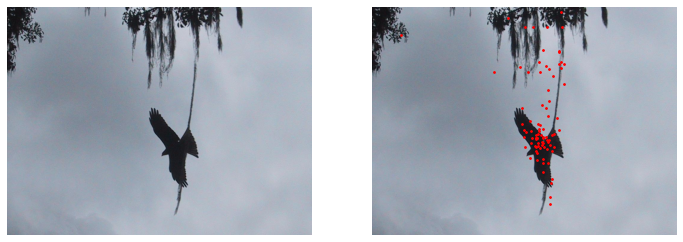

In [36]:
#showing for a sample image in dataset
import matplotlib.pyplot as plt

index = 56

plt.figure(figsize=(12,6))

plt.subplot(1,2,1)
plt.imshow(mit_stimuli.stimuli[index])
_ = plt.axis('off')

plt.subplot(1,2,2)

plt.imshow(mit_stimuli.stimuli[index])
f = mit_fixations[mit_fixations.n == index]
plt.scatter(f.x, f.y, color='r', s=3)
_ = plt.axis('off')

**center bias density of MIT1003:**

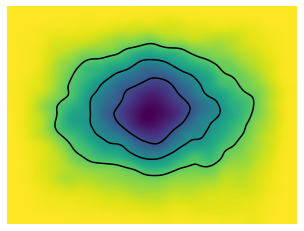

In [37]:
import pysaliency.plotting
image = mit_stimuli[56]
log_baseline =baseline.log_density(image)
pysaliency.plotting.visualize_distribution(log_baseline )
_ = plt.axis('off')
#this center bias is the same for all stimulies

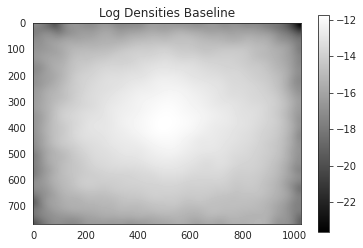

In [38]:
import matplotlib.pyplot as plt

plt.imshow(log_baseline, 'gray')
plt.colorbar()
plt.title('Log Densities Baseline');

**Gold Standard Kernel density estimate predictions over the salicon stimuli:**

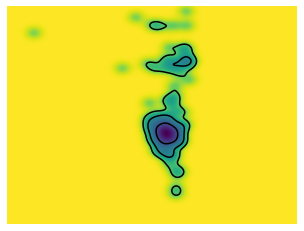

In [39]:
import pysaliency.plotting
image = mit_stimuli[56]
log_KDE_gold =KDE_gold.log_density(image)
pysaliency.plotting.visualize_distribution(log_KDE_gold )
_ = plt.axis('off')

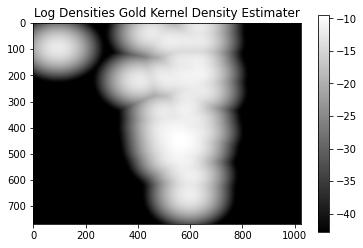

In [12]:
import matplotlib.pyplot as plt

plt.imshow(log_KDE_gold, 'gray')
plt.colorbar()
plt.title('Log Densities Gold Kernel Density Estimater');

plot for the report!

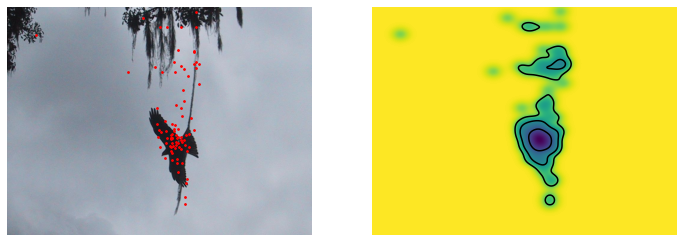

In [41]:
plt.figure(figsize=(12,12))

plt.subplot(1,2,1)

plt.imshow(mit_stimuli.stimuli[index])
f = mit_fixations[mit_fixations.n == index]
plt.scatter(f.x, f.y, color='r', s=3)
_ = plt.axis('off')

plt.subplot(1,2,2)
import pysaliency.plotting
image = mit_stimuli[56]
log_KDE_gold =KDE_gold.log_density(image)
pysaliency.plotting.visualize_distribution(log_KDE_gold )
_ = plt.axis('off')



**SALICON Dataset for training the readout network**

In [13]:
#SALICON Dataset for training the readout network
from tqdm import tqdm
from scipy.io import loadmat

!gdown --id "1g8j-hTT-51IG1UFwP0xTGhLdgIUCW5e5"
!gdown --id "1PnO7szbdub1559LfjYHMy65EDC4VhJC8"
!gdown --id "1P-jeZXCsjoKO79OhFUgnj6FGcyvmLDPj"

!mkdir "/content/salicon"
!mkdir "/content/salicon/saliencymap/"
!mkdir "/content/salicon/fixations/"

!unzip -q maps.zip -d './salicon/saliencymap'


temp_dir = './'
print("Extracting stimuli")

f = zipfile.ZipFile('./images.zip')
f.extractall(temp_dir)


salicon_train_stimuli_name = [os.path.basename(f) for f in sorted(glob.glob(os.path.join(temp_dir, 'images', 'train', 'COCO_train*')))]
salicon_stimuli_train = create_stimuli(
    stimuli_location=os.path.join(temp_dir, 'images', 'train'),
    filenames= salicon_train_stimuli_name,
    location = './salicon/stimuli/train')


salicon_val_stimuli_name = [os.path.basename(f) for f in sorted(glob.glob(os.path.join(temp_dir, 'images', 'val', 'COCO_val*')))]
salicon_stimuli_val = create_stimuli(
    stimuli_location=os.path.join(temp_dir, 'images', 'val'),
    filenames= salicon_val_stimuli_name,
    location = './salicon/stimuli/val')


salicon_test_stimuli_name = [os.path.basename(f) for f in sorted(glob.glob(os.path.join(temp_dir, 'images', 'test', 'COCO_test*')))]
salicon_stimuli_test = create_stimuli(
    stimuli_location=os.path.join(temp_dir, 'images', 'test'),
    filenames= salicon_test_stimuli_name,
    location = './salicon/stimuli/test')


f = zipfile.ZipFile('./fixations.zip')
f.extractall('/content/salicon/fixations/')

fixations = []

fixation_attr = 'fixations'
fixation_type =  'fixations'
for dataset in ['train', 'val']:
    ns = []
    train_xs = []
    train_ys = []
    train_ts = []
    train_subjects = []

    subject_id = 0

    data_files = list(sorted(glob.glob(os.path.join('/content/salicon/fixations', dataset, '*.mat'))))
    for n, filename in enumerate(tqdm(data_files)):
        fixation_data = loadmat(filename)
        for subject_data in fixation_data['gaze'].flatten():
            train_xs.append(subject_data[fixation_attr][:, 0] - 1)  # matlab: one-based indexing
            train_ys.append(subject_data[fixation_attr][:, 1] - 1)
            if fixation_type == 'mouse':
                train_ts.append(subject_data['timestamp'].flatten())
            elif fixation_type == 'fixations':
                train_ts.append(range(len(train_xs[-1])))

            train_subjects.append(np.ones(len(train_xs[-1]), dtype=int) * subject_id)
            ns.append(np.ones(len(train_xs[-1]), dtype=int) * n)
            subject_id += 1

    xs = np.hstack(train_xs)
    ys = np.hstack(train_ys)
    ts = np.hstack(train_ts)
    subjects = np.hstack(train_subjects)
    ns = np.hstack(ns)

    fixations.append(Fixations.FixationsWithoutHistory(xs, ys, ts, ns, subjects))

salicon_fixations_train, salicon_fixations_val = fixations

import os 
os.remove("./images.zip")
os.remove("./maps.zip")

Downloading...
From: https://drive.google.com/uc?id=1g8j-hTT-51IG1UFwP0xTGhLdgIUCW5e5
To: /content/images.zip
2.27GB [00:20, 113MB/s]
Downloading...
From: https://drive.google.com/uc?id=1PnO7szbdub1559LfjYHMy65EDC4VhJC8
To: /content/maps.zip
452MB [00:04, 112MB/s] 
Downloading...
From: https://drive.google.com/uc?id=1P-jeZXCsjoKO79OhFUgnj6FGcyvmLDPj
To: /content/fixations.zip
1.54GB [00:23, 64.3MB/s]
Extracting stimuli


100%|██████████| 5000/5000 [00:22<00:00, 220.33it/s]


In [14]:
bandwidth = 0.0217
regularization = 2.0e-13
from .baseline_utils import BaselineModel , KDEGoldModel

baseline = BaselineModel(salicon_stimuli_train, salicon_fixations_train, bandwidth=bandwidth, eps=regularization)

KDE_gold = KDEGoldModel(salicon_stimuli_train, salicon_fixations_train, bandwidth=bandwidth, eps=regularization)

**Visualizing an stimuli from SALICON + fixations :**

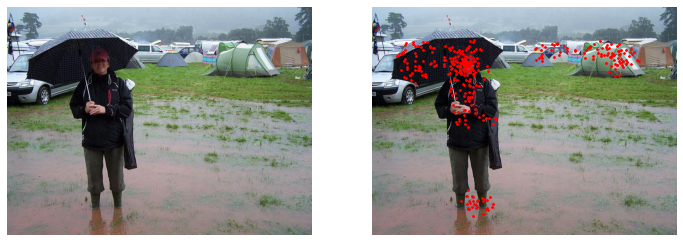

In [15]:
#showing for a sample image in dataset
import matplotlib.pyplot as plt

index = 18

plt.figure(figsize=(12,6))

plt.subplot(1,2,1)
plt.imshow(salicon_stimuli_train.stimuli[index])
_ = plt.axis('off')

plt.subplot(1,2,2)

plt.imshow(salicon_stimuli_train.stimuli[index])
f = salicon_fixations_train[salicon_fixations_train.n == index]
plt.scatter(f.x, f.y, color='r', s=3)
_ = plt.axis('off')

**center bias density of SALICON:**

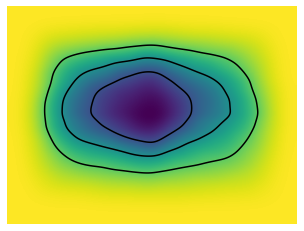

In [22]:
import pysaliency.plotting
image = salicon_stimuli_train[18]
log_baseline =baseline.log_density(image)
pysaliency.plotting.visualize_distribution(log_baseline )
_ = plt.axis('off')

#this center bias is the same for all stimulies

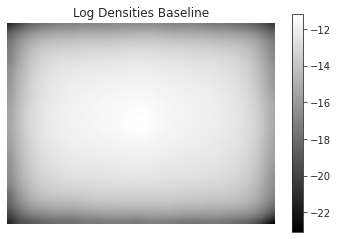

In [23]:
import matplotlib.pyplot as plt

plt.imshow(log_baseline, 'gray')
plt.colorbar()
plt.title('Log Densities Baseline');
_ = plt.axis('off')

Image contained in the report

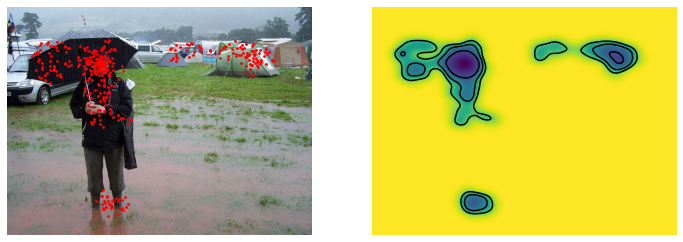

In [30]:
plt.figure(figsize=(12,12))

plt.subplot(1,2,1)
index = 18
plt.imshow(salicon_stimuli_train.stimuli[index])
f = salicon_fixations_train[salicon_fixations_train.n == index]
plt.scatter(f.x, f.y, color='r', s=3)
_ = plt.axis('off')

import pysaliency.plotting
plt.subplot(1,2,2)
image = salicon_stimuli_train[18]
log_KDE_gold =KDE_gold.log_density(image)
pysaliency.plotting.visualize_distribution(log_KDE_gold )
_ = plt.axis('off')

**Gold Standard Kernel density estimate predictions over the salicon stimuli:**

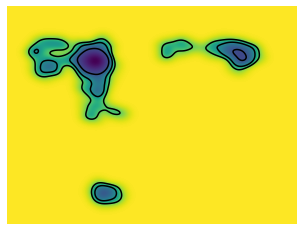

In [31]:
import pysaliency.plotting
image = salicon_stimuli_train[18]
log_KDE_gold =KDE_gold.log_density(image)
pysaliency.plotting.visualize_distribution(log_KDE_gold )
_ = plt.axis('off')

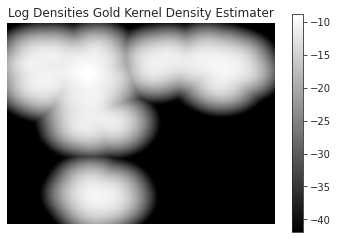

In [26]:
import matplotlib.pyplot as plt

plt.imshow(log_KDE_gold, 'gray')
plt.colorbar()
plt.title('Log Densities Gold Kernel Density Estimater');
_ = plt.axis('off')

**Predictions of authors checkpointed ICF Model on a popout image:**


(-0.5, 285.5, 285.5, -0.5)

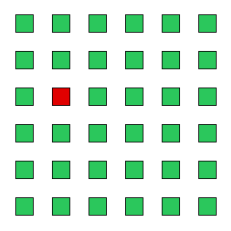

In [51]:
%matplotlib inline

import numpy as np

import matplotlib.pyplot as plt

import pandas as pd

import seaborn as sns
sns.set_style('white')

import tensorflow as tf

# our example image for which we will calculate DeepGaze predictions

from scipy.misc import face
img1 = face()
img2 = plt.imread('./Popout.png')
plt.imshow(img2)
plt.axis('off')

'model_variables' collection should be of type 'byte_list', but instead is of type 'node_list'.


'model_variables' collection should be of type 'byte_list', but instead is of type 'node_list'.


INFO:tensorflow:Restoring parameters from ICF.ckpt


INFO:tensorflow:Restoring parameters from ICF.ckpt


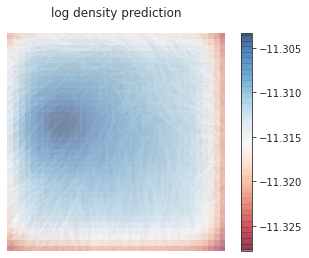

In [52]:
image_data = img2[np.newaxis, :, :, :]  # BHWC, three channels (RGB)
centerbias_data = np.zeros((1, img2.shape[0], img2.shape[1], 1))  # BHWC, 1 channel (log density)
from tensorflow.python.framework import ops
ops.reset_default_graph()

import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

sess=tf.Session()    
#First let's load meta graph and restore weights
saver = tf.train.import_meta_graph('ICF.ckpt.meta')


# Now, let's access and create placeholders variables and
# create feed-dict to feed new data
 
graph = tf.get_default_graph()


input_tensor = tf.get_collection('input_tensor')[0]
centerbias_tensor = tf.get_collection('centerbias_tensor')[0]
log_density = tf.get_collection('log_density')[0]
log_density_wo_centerbias = tf.get_collection('log_density_wo_centerbias')[0]

with tf.Session() as sess:
    
    saver.restore(sess,'ICF.ckpt')
    
    log_density_prediction = sess.run(log_density, {
        input_tensor: image_data,
        centerbias_tensor: centerbias_data,
    })

plt.gca().imshow(img, alpha=0.2)
m = plt.gca().matshow((log_density_prediction[0, :, :, 0]), alpha=0.5, cmap=plt.cm.RdBu)
plt.colorbar(m)
plt.title('log density prediction')
plt.axis('off');



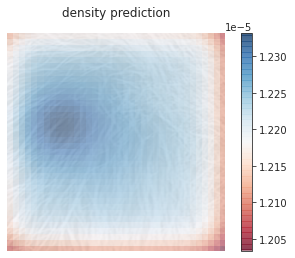

In [53]:
plt.gca().imshow(img, alpha=0.2)
m = plt.gca().matshow(np.exp(log_density_prediction[0, :, :, 0]), alpha=0.5, cmap=plt.cm.RdBu)
plt.colorbar(m)
plt.title('density prediction')
plt.axis('off');

**Predictions of authors checkpointed Deep Gaze 2 Model:**

'model_variables' collection should be of type 'byte_list', but instead is of type 'node_list'.


'model_variables' collection should be of type 'byte_list', but instead is of type 'node_list'.


INFO:tensorflow:Restoring parameters from DeepGazeII.ckpt


INFO:tensorflow:Restoring parameters from DeepGazeII.ckpt


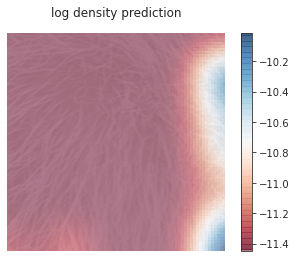

In [54]:
ops.reset_default_graph()

import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

sess=tf.Session()    
#First let's load meta graph and restore weights
saver2 = tf.train.import_meta_graph('DeepGazeII.ckpt.meta')


# Now, let's access and create placeholders variables and
# create feed-dict to feed new data
 
graph = tf.get_default_graph()


input_tensor = tf.get_collection('input_tensor')[0]
centerbias_tensor = tf.get_collection('centerbias_tensor')[0]
log_density = tf.get_collection('log_density')[0]
log_density_wo_centerbias = tf.get_collection('log_density_wo_centerbias')[0]

with tf.Session() as sess:
    
    saver.restore(sess,'DeepGazeII.ckpt')
    
    log_density_prediction = sess.run(log_density, {
        input_tensor: image_data,
        centerbias_tensor: centerbias_data,
    })

plt.gca().imshow(img, alpha=0.2)
m = plt.gca().matshow((log_density_prediction[0, :, :, 0]), alpha=0.5, cmap=plt.cm.RdBu)
plt.colorbar(m)
plt.title('log density prediction')
plt.axis('off');


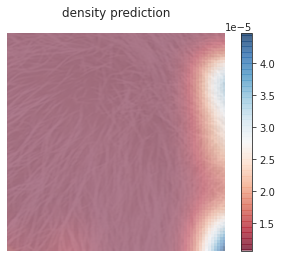

In [55]:

plt.gca().imshow(img, alpha=0.2)
m = plt.gca().matshow(np.exp(log_density_prediction[0, :, :, 0]), alpha=0.5, cmap=plt.cm.RdBu)
plt.colorbar(m)
plt.title('density prediction')
plt.axis('off');

**Testing the models on a high-level fixation driven image:**

'model_variables' collection should be of type 'byte_list', but instead is of type 'node_list'.


'model_variables' collection should be of type 'byte_list', but instead is of type 'node_list'.


INFO:tensorflow:Restoring parameters from ICF.ckpt


INFO:tensorflow:Restoring parameters from ICF.ckpt


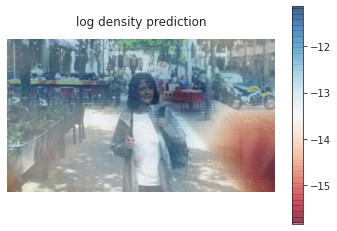

In [57]:
from scipy.misc import face
img1 = face()
img2 = plt.imread('./unnamed.jpg')
plt.imshow(img2)
plt.axis('off')

image_data = img2[np.newaxis, :, :, :]  # BHWC, three channels (RGB)
centerbias_data = np.zeros((1, img2.shape[0], img2.shape[1], 1))  # BHWC, 1 channel (log density)
from tensorflow.python.framework import ops
ops.reset_default_graph()

import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

sess=tf.Session()    
#First let's load meta graph and restore weights
saver = tf.train.import_meta_graph('ICF.ckpt.meta')


# Now, let's access and create placeholders variables and
# create feed-dict to feed new data
 
graph = tf.get_default_graph()


input_tensor = tf.get_collection('input_tensor')[0]
centerbias_tensor = tf.get_collection('centerbias_tensor')[0]
log_density = tf.get_collection('log_density')[0]
log_density_wo_centerbias = tf.get_collection('log_density_wo_centerbias')[0]

with tf.Session() as sess:
    
    saver.restore(sess,'ICF.ckpt')
    
    log_density_prediction = sess.run(log_density, {
        input_tensor: image_data,
        centerbias_tensor: centerbias_data,
    })

plt.gca().imshow(img, alpha=0.2)
m = plt.gca().matshow((log_density_prediction[0, :, :, 0]), alpha=0.5, cmap=plt.cm.RdBu)
plt.colorbar(m)
plt.title('log density prediction')
plt.axis('off');



'model_variables' collection should be of type 'byte_list', but instead is of type 'node_list'.


'model_variables' collection should be of type 'byte_list', but instead is of type 'node_list'.


INFO:tensorflow:Restoring parameters from DeepGazeII.ckpt


INFO:tensorflow:Restoring parameters from DeepGazeII.ckpt


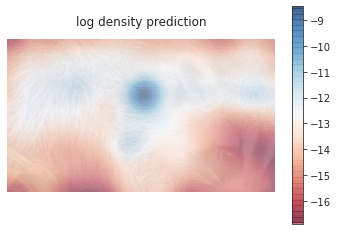

In [58]:
ops.reset_default_graph()

import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

sess=tf.Session()    
#First let's load meta graph and restore weights
saver2 = tf.train.import_meta_graph('DeepGazeII.ckpt.meta')


# Now, let's access and create placeholders variables and
# create feed-dict to feed new data
 
graph = tf.get_default_graph()


input_tensor = tf.get_collection('input_tensor')[0]
centerbias_tensor = tf.get_collection('centerbias_tensor')[0]
log_density = tf.get_collection('log_density')[0]
log_density_wo_centerbias = tf.get_collection('log_density_wo_centerbias')[0]

with tf.Session() as sess:
    
    saver.restore(sess,'DeepGazeII.ckpt')
    
    log_density_prediction = sess.run(log_density, {
        input_tensor: image_data,
        centerbias_tensor: centerbias_data,
    })

plt.gca().imshow(img, alpha=0.2)
m = plt.gca().matshow((log_density_prediction[0, :, :, 0]), alpha=0.5, cmap=plt.cm.RdBu)
plt.colorbar(m)
plt.title('log density prediction')
plt.axis('off');
